In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

In [2]:
## Calulcating metrics
def calculate_metrics(df, crop_names, y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test,y_pred)
    y_test_avg = pd.DataFrame(y_test).mean().iloc[0]
    y_pred_avg = pd.DataFrame(y_pred).mean().iloc[0]
    df.loc[crop_names] = [mae, mse, rmse, mape, r2, y_test_avg, y_pred_avg]


In [5]:
fao_data = pd.read_csv("datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data['Crop_season'].value_counts()

Spring        591
Summer        381
Year-Round    274
Autumn        152
Fall          145
Winter         31
Name: Crop_season, dtype: int64

In [6]:
fao_data['Category'].value_counts()

Vegetables and Legumes    670
Fruits and Nuts           450
Industrial_crops          237
Cereals                   217
Name: Category, dtype: int64

In [7]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals',
       'Industrial_crops'], dtype=object)

In [8]:
quality_metrics = ['Random_forest_MAE', 'Random_forest_MSE', 'Random_forest_RMSE', 'Random_forest_MAPE','Random_forest_r2_score', 'y_test_avg', 'y_pred_avg']
error_df = pd.DataFrame(columns = quality_metrics, index = cat_names)
display(error_df)

,Random_forest_MAE,Random_forest_MSE,Random_forest_RMSE,Random_forest_MAPE,Random_forest_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vegetables and Legumes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cereals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industrial_crops,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')

    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    

    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)

    x = scaler.fit_transform(x)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
    regressor = RandomForestRegressor(n_estimators = 500, random_state = 42) #max_depth= 150)
    regressor.fit(x_train, y_train)
    
    #prediction of new value
    y_pred = regressor.predict(x_test)
    calculate_metrics(error_df, cat , pd.DataFrame(y_test), y_pred)

In [14]:
error_df

,Random_forest_MAE,Random_forest_MSE,Random_forest_RMSE,Random_forest_MAPE,Random_forest_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,3.447211,26.872046,5.183825,0.497975,0.469339,9.62286,10.159391
Vegetables and Legumes,13.250847,535.24241,23.135307,0.816383,0.849853,45.745672,38.45131
Cereals,0.500306,0.558577,0.74738,0.577647,0.904303,0.038645,0.214377
Industrial_crops,0.555108,0.66574,0.815929,1.516269,0.616664,0.030727,-0.053095


In [16]:
error_df

,Random_forest_MAE,Random_forest_MSE,Random_forest_RMSE,Random_forest_MAPE,Random_forest_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,3.447211,26.872046,5.183825,0.497975,0.469339,9.62286,10.159391
Vegetables and Legumes,13.250847,535.24241,23.135307,0.816383,0.849853,45.745672,38.45131
Cereals,0.500306,0.558577,0.74738,0.577647,0.904303,0.038645,0.214377
Industrial_crops,0.555108,0.66574,0.815929,1.516269,0.616664,0.030727,-0.053095


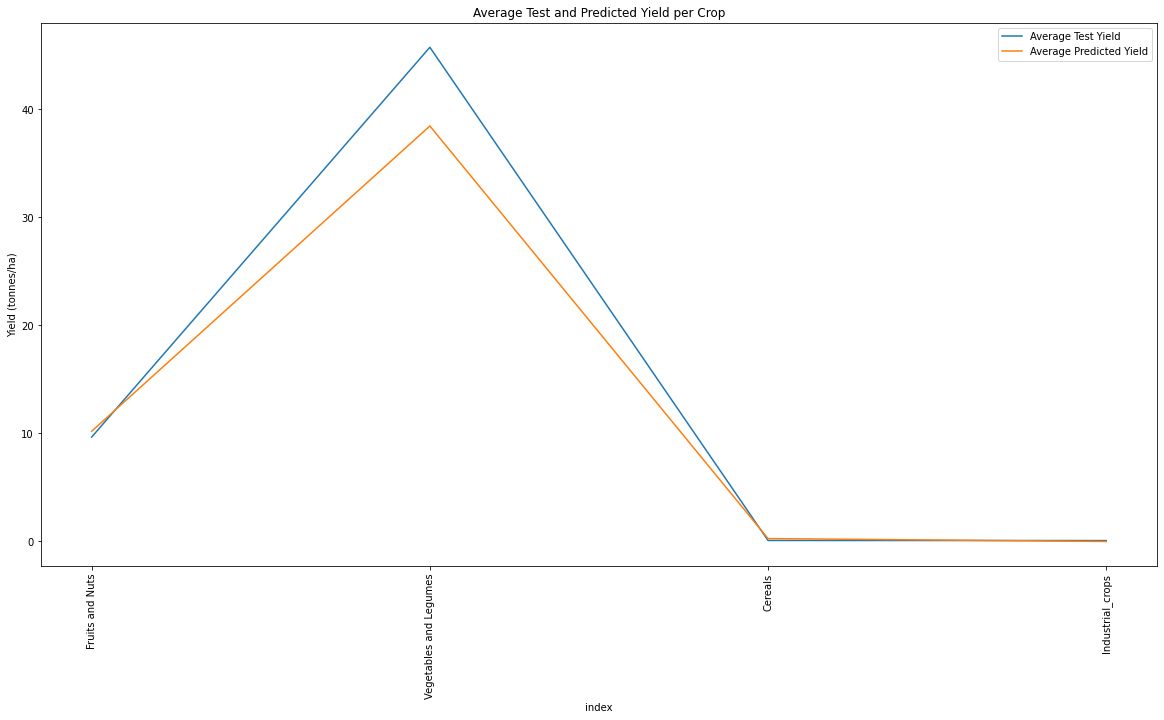

In [15]:
avg_df = error_df[['y_test_avg', 'y_pred_avg']].reset_index()



#create a line plot of the average test and predicted yield per crop
plt.figure(figsize=(20, 10))
plt.plot(avg_df['index'], avg_df['y_test_avg'], label='Average Test Yield')
plt.plot(avg_df['index'], avg_df['y_pred_avg'], label='Average Predicted Yield')
plt.xticks(rotation=90)
plt.xlabel('index')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Average Test and Predicted Yield per Crop')
plt.legend()
plt.show()